# Natural Language Processing Challenge - Data Exploration

## Project Overview

This notebook explores a dataset containing news articles to identify whether a news headline is real or fake news.

### Dataset Information
- **Training Data**: `dataset/data.csv` (39,998 articles)
- **Validation Data**: `dataset/validation_data.csv` (4,956 articles)

### Columns
- **`label`**: 0 if fake news, 1 if real news
- **`title`**: The headline of the news article
- **`text`**: The full content of the article
- **`subject`**: The category or topic of the news
- **`date`**: The publication date of the article

### Goal
Build a classifier to distinguish between real and fake news, then predict labels for the validation dataset.

## 1. Setup and Imports

In [1]:
# Standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text processing libraries
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# Visualization settings - using basic matplotlib to avoid seaborn compatibility issues
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package wordnet to /Users/sergej/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load and Explore the Data

In [2]:
# Load the training data
print("Loading training data...")
train_data = pd.read_csv('dataset/data.csv')
print(f"Training data shape: {train_data.shape}")

# Load the validation data
print("\nLoading validation data...")
validation_data = pd.read_csv('dataset/validation_data.csv')
print(f"Validation data shape: {validation_data.shape}")

print("\n✅ Data loaded successfully!")

Loading training data...
Training data shape: (39942, 5)

Loading validation data...
Validation data shape: (4956, 5)

✅ Data loaded successfully!


In [3]:
# Display basic information about the datasets
print("=== TRAINING DATA INFO ===")
print(train_data.info())
print("\n=== VALIDATION DATA INFO ===")
print(validation_data.info())

=== TRAINING DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39942 entries, 0 to 39941
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    39942 non-null  int64 
 1   title    39942 non-null  object
 2   text     39942 non-null  object
 3   subject  39942 non-null  object
 4   date     39942 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB
None

=== VALIDATION DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4956 entries, 0 to 4955
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    4956 non-null   int64 
 1   title    4956 non-null   object
 2   text     4956 non-null   object
 3   subject  4956 non-null   object
 4   date     4956 non-null   object
dtypes: int64(1), object(4)
memory usage: 193.7+ KB
None


In [4]:
# Display first few rows of training data
print("=== TRAINING DATA PREVIEW ===")
print(train_data.head())
print("\n=== VALIDATION DATA PREVIEW ===")
print(validation_data.head())

=== TRAINING DATA PREVIEW ===
   label                                              title  \
0      1  As U.S. budget fight looms, Republicans flip t...   
1      1  U.S. military to accept transgender recruits o...   
2      1  Senior U.S. Republican senator: 'Let Mr. Muell...   
3      1  FBI Russia probe helped by Australian diplomat...   
4      1  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   

=== VALIDATION DATA PREVI

In [5]:
# Check for missing values
print("=== MISSING VALUES IN TRAINING DATA ===")
print(train_data.isnull().sum())
print("\n=== MISSING VALUES IN VALIDATION DATA ===")
print(validation_data.isnull().sum())

=== MISSING VALUES IN TRAINING DATA ===
label      0
title      0
text       0
subject    0
date       0
dtype: int64

=== MISSING VALUES IN VALIDATION DATA ===
label      0
title      0
text       0
subject    0
date       0
dtype: int64


In [6]:
# Check data types
print("=== TRAINING DATA TYPES ===")
print(train_data.dtypes)
print("\n=== VALIDATION DATA TYPES ===")
print(validation_data.dtypes)

=== TRAINING DATA TYPES ===
label       int64
title      object
text       object
subject    object
date       object
dtype: object

=== VALIDATION DATA TYPES ===
label       int64
title      object
text       object
subject    object
date       object
dtype: object


## 3. Data Distribution Analysis

=== LABEL DISTRIBUTION ===
Training data:
label
1    19999
0    19943
Name: count, dtype: int64

Fake news percentage: 49.93%
Real news percentage: 50.07%


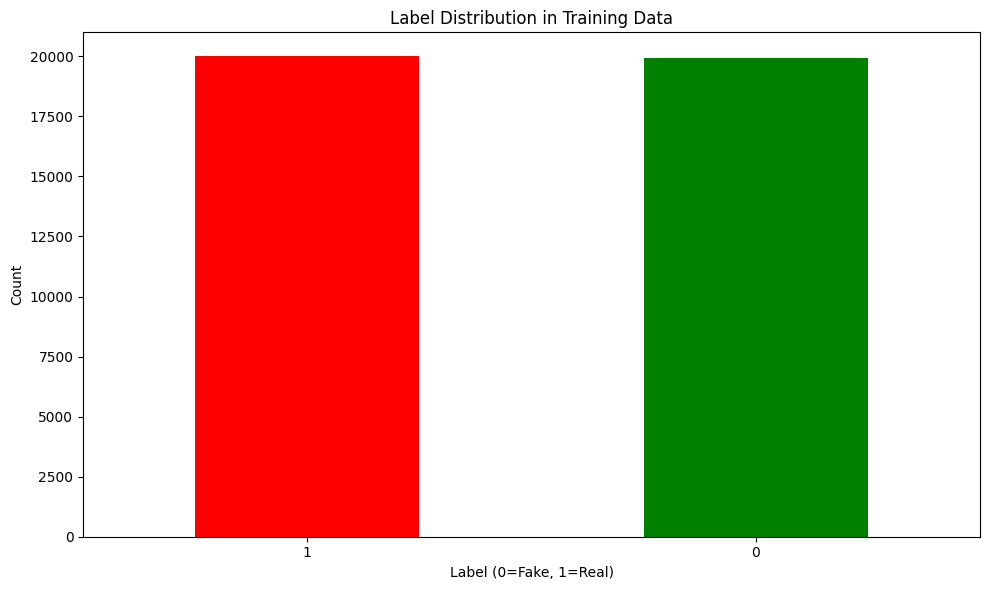

In [7]:
# Analyze label distribution
print("=== LABEL DISTRIBUTION ===")
print("Training data:")
print(train_data['label'].value_counts())
print(f"\nFake news percentage: {(train_data['label'] == 0).mean() * 100:.2f}%")
print(f"Real news percentage: {(train_data['label'] == 1).mean() * 100:.2f}%")

# Visualize label distribution
plt.figure(figsize=(10, 6))
train_data['label'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Label Distribution in Training Data')
plt.xlabel('Label (0=Fake, 1=Real)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

=== SUBJECT DISTRIBUTION ===
subject
politicsNews       11272
News                9050
worldnews           8727
politics            6841
left-news           2482
Government News     1570
Name: count, dtype: int64


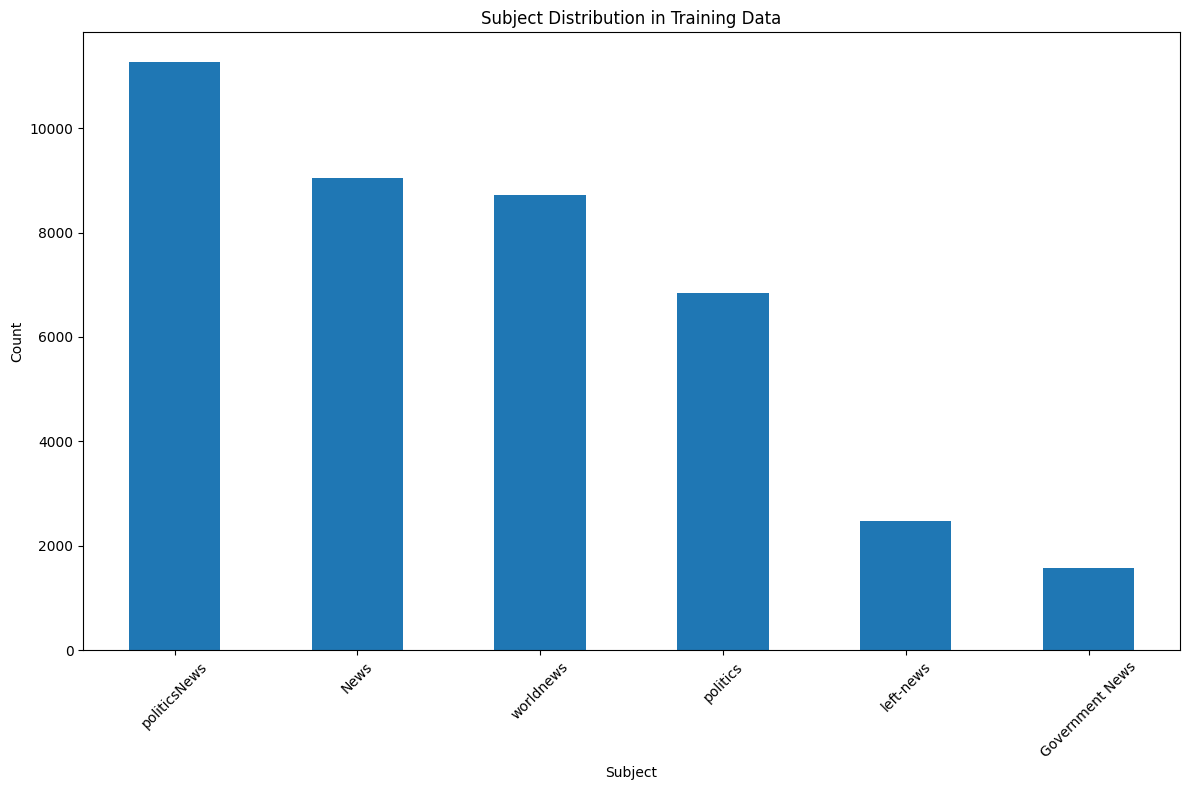

In [8]:
# Analyze subject distribution
print("=== SUBJECT DISTRIBUTION ===")
print(train_data['subject'].value_counts())

# Visualize subject distribution
plt.figure(figsize=(12, 8))
train_data['subject'].value_counts().plot(kind='bar')
plt.title('Subject Distribution in Training Data')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== DATE ANALYSIS ===
Date parsing results:
Training data - Successfully parsed: 39,934 (100.0%)
Training data - Parsing errors: 8 (0.0%)
Validation data - Successfully parsed: 4,954 (100.0%)
Validation data - Parsing errors: 2 (0.0%)

Sample problematic dates from training data:
29357    https://100percentfedup.com/served-roy-moore-v...
35506    https://100percentfedup.com/video-hillary-aske...
35507    https://100percentfedup.com/12-yr-old-black-co...
35838    https://fedup.wpengine.com/wp-content/uploads/...
35839    https://fedup.wpengine.com/wp-content/uploads/...
37431    https://fedup.wpengine.com/wp-content/uploads/...
37432    https://fedup.wpengine.com/wp-content/uploads/...
38932    MSNBC HOST Rudely Assumes Steel Worker Would N...
Name: date_clean, dtype: object

Date range in training data: 2015-03-31 00:00:00 to 2018-02-19 00:00:00


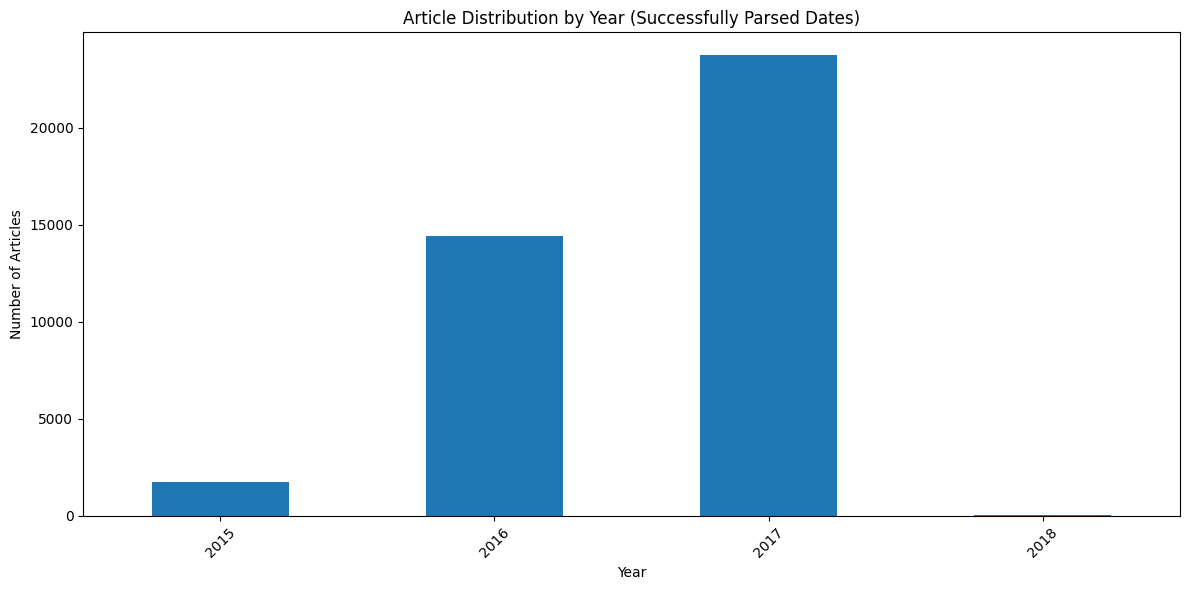

In [9]:
# Analyze date distribution with comprehensive parsing
print("=== DATE ANALYSIS ===")

# Clean date strings by removing extra spaces
train_data['date_clean'] = train_data['date'].str.strip()
validation_data['date_clean'] = validation_data['date'].str.strip()

# Function to parse dates with multiple formats
def parse_dates_robust(date_series):
    """Parse dates with multiple format support"""
    # Try different date formats
    formats = [
        '%B %d, %Y',      # December 20, 2017
        '%d-%b-%y',       # 19-Feb-18
        '%Y-%m-%d',       # 2017-12-20
        '%m/%d/%Y',       # 12/20/2017
        '%d/%m/%Y',       # 20/12/2017
    ]
    
    parsed_dates = pd.Series([pd.NaT] * len(date_series), index=date_series.index)
    
    for fmt in formats:
        try:
            # Try to parse with current format
            temp_parsed = pd.to_datetime(date_series, format=fmt, errors='coerce')
            # Update only the ones that weren't parsed yet
            mask = parsed_dates.isna() & temp_parsed.notna()
            parsed_dates[mask] = temp_parsed[mask]
        except:
            continue
    
    # Try pandas automatic parsing for any remaining
    remaining_mask = parsed_dates.isna()
    if remaining_mask.any():
        try:
            auto_parsed = pd.to_datetime(date_series[remaining_mask], errors='coerce')
            parsed_dates[remaining_mask] = auto_parsed
        except:
            pass
    
    return parsed_dates

# Parse dates
train_data['date_parsed'] = parse_dates_robust(train_data['date_clean'])
validation_data['date_parsed'] = parse_dates_robust(validation_data['date_clean'])

# Check parsing results
train_parse_errors = train_data['date_parsed'].isna().sum()
val_parse_errors = validation_data['date_parsed'].isna().sum()

print(f"Date parsing results:")
print(f"Training data - Successfully parsed: {len(train_data) - train_parse_errors:,} ({((len(train_data) - train_parse_errors) / len(train_data) * 100):.1f}%)")
print(f"Training data - Parsing errors: {train_parse_errors:,} ({train_parse_errors / len(train_data) * 100:.1f}%)")
print(f"Validation data - Successfully parsed: {len(validation_data) - val_parse_errors:,} ({((len(validation_data) - val_parse_errors) / len(validation_data) * 100):.1f}%)")
print(f"Validation data - Parsing errors: {val_parse_errors:,} ({val_parse_errors / len(validation_data) * 100:.1f}%)")

if train_parse_errors > 0:
    print("\nSample problematic dates from training data:")
    print(train_data[train_data['date_parsed'].isna()]['date_clean'].head(10))

# Show date range for successfully parsed dates
if train_parse_errors < len(train_data):
    valid_dates = train_data['date_parsed'].dropna()
    print(f"\nDate range in training data: {valid_dates.min()} to {valid_dates.max()}")
    
    # Visualize date distribution by year
    plt.figure(figsize=(12, 6))
    valid_dates.dt.year.value_counts().sort_index().plot(kind='bar')
    plt.title('Article Distribution by Year (Successfully Parsed Dates)')
    plt.xlabel('Year')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo dates could be parsed successfully.")
    print("\nSample date values:")
    print(train_data['date_clean'].head(10))
    print("\nUnique date formats:")
    print(train_data['date_clean'].value_counts().head(10))

In [10]:
# Analyze text and title lengths
print("=== TEXT AND TITLE LENGTH ANALYSIS ===")

# Calculate lengths
train_data['text_length'] = train_data['text'].str.len()
train_data['title_length'] = train_data['title'].str.len()
train_data['word_count'] = train_data['text'].str.split().str.len()
train_data['title_word_count'] = train_data['title'].str.split().str.len()

print(f"Text length statistics:")
print(train_data['text_length'].describe())
print(f"\nTitle length statistics:")
print(train_data['title_length'].describe())
print(f"\nWord count statistics:")
print(train_data['word_count'].describe())
print(f"\nTitle word count statistics:")
print(train_data['title_word_count'].describe())

=== TEXT AND TITLE LENGTH ANALYSIS ===
Text length statistics:
count    39942.000000
mean      2384.637875
std       1765.895463
min          1.000000
25%       1259.000000
50%       2197.000000
75%       3069.000000
max      49705.000000
Name: text_length, dtype: float64

Title length statistics:
count    39942.000000
mean        79.774723
std         24.811136
min          8.000000
25%         63.000000
50%         73.000000
75%         90.000000
max        286.000000
Name: title_length, dtype: float64

Word count statistics:
count    39942.000000
mean       391.735867
std        286.378195
min          0.000000
25%        207.000000
50%        363.500000
75%        506.000000
max       7033.000000
Name: word_count, dtype: float64

Title word count statistics:
count    39942.000000
mean        12.392870
std          4.038761
min          1.000000
25%         10.000000
50%         11.000000
75%         14.000000
max         42.000000
Name: title_word_count, dtype: float64


=== LENGTH DISTRIBUTIONS BY LABEL ===


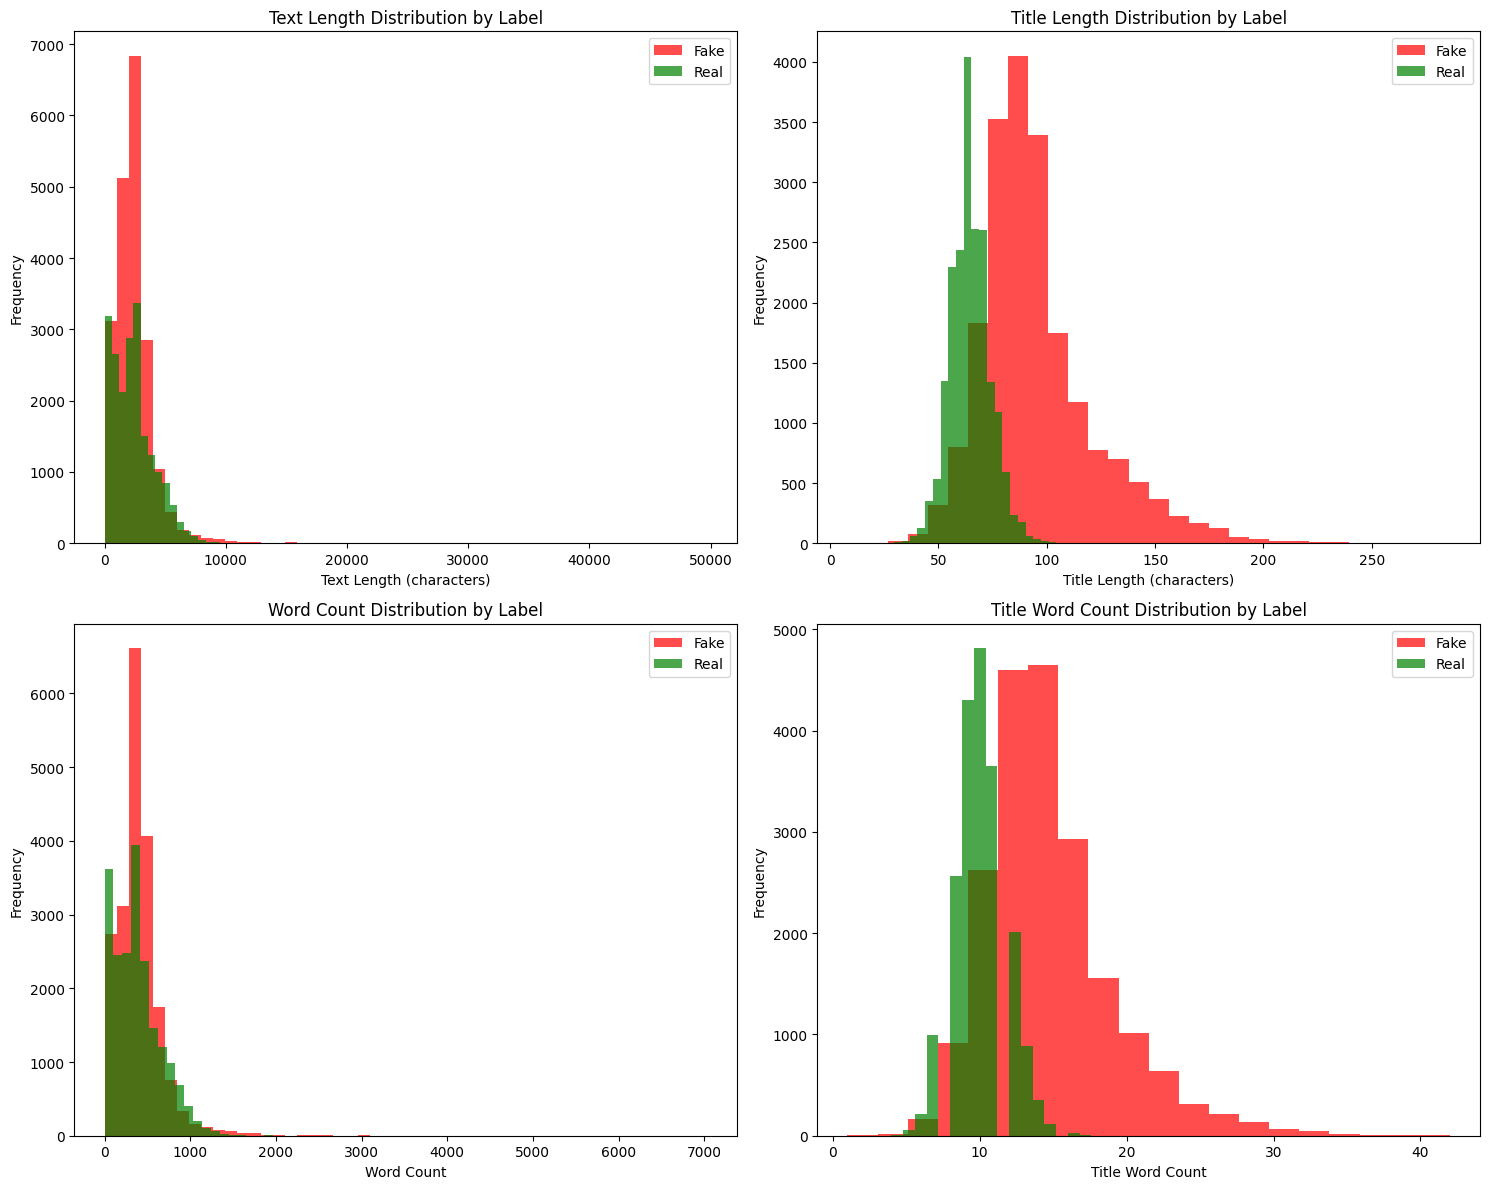

In [11]:
# Visualize length distributions by label
print("=== LENGTH DISTRIBUTIONS BY LABEL ===")

# Separate fake and real news
fake_news = train_data[train_data['label'] == 0]
real_news = train_data[train_data['label'] == 1]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(fake_news['text_length'], bins=50, alpha=0.7, label='Fake', color='red')
axes[0, 0].hist(real_news['text_length'], bins=50, alpha=0.7, label='Real', color='green')
axes[0, 0].set_title('Text Length Distribution by Label')
axes[0, 0].set_xlabel('Text Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

axes[0, 1].hist(fake_news['title_length'], bins=30, alpha=0.7, label='Fake', color='red')
axes[0, 1].hist(real_news['title_length'], bins=30, alpha=0.7, label='Real', color='green')
axes[0, 1].set_title('Title Length Distribution by Label')
axes[0, 1].set_xlabel('Title Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

axes[1, 0].hist(fake_news['word_count'], bins=50, alpha=0.7, label='Fake', color='red')
axes[1, 0].hist(real_news['word_count'], bins=50, alpha=0.7, label='Real', color='green')
axes[1, 0].set_title('Word Count Distribution by Label')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

axes[1, 1].hist(fake_news['title_word_count'], bins=20, alpha=0.7, label='Fake', color='red')
axes[1, 1].hist(real_news['title_word_count'], bins=20, alpha=0.7, label='Real', color='green')
axes[1, 1].set_title('Title Word Count Distribution by Label')
axes[1, 1].set_xlabel('Title Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 4. Text Preprocessing Functions

In [12]:
# Text preprocessing functions
def clean_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def remove_stopwords(text):
    """Remove stopwords from text"""
    if pd.isna(text):
        return ""
    
    try:
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    except:
        return text

def lemmatize_text(text):
    """Lemmatize text"""
    if pd.isna(text):
        return ""
    
    try:
        lemmatizer = WordNetLemmatizer()
        words = word_tokenize(text)
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)
    except:
        return text

def preprocess_text(text):
    """Complete text preprocessing pipeline"""
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

print("Text preprocessing functions defined!")

Text preprocessing functions defined!


## 5. Word Frequency Analysis

=== WORD FREQUENCY ANALYSIS ===
Most common words in all articles:
trump: 122117
said: 118254
u: 54189
state: 51728
would: 49438
president: 48701
republican: 37084
people: 36420
one: 31535
year: 30011
reuters: 26711
new: 26710
also: 26608
donald: 25991
house: 25842
clinton: 24311
government: 24207
time: 22899
obama: 21929
say: 21899


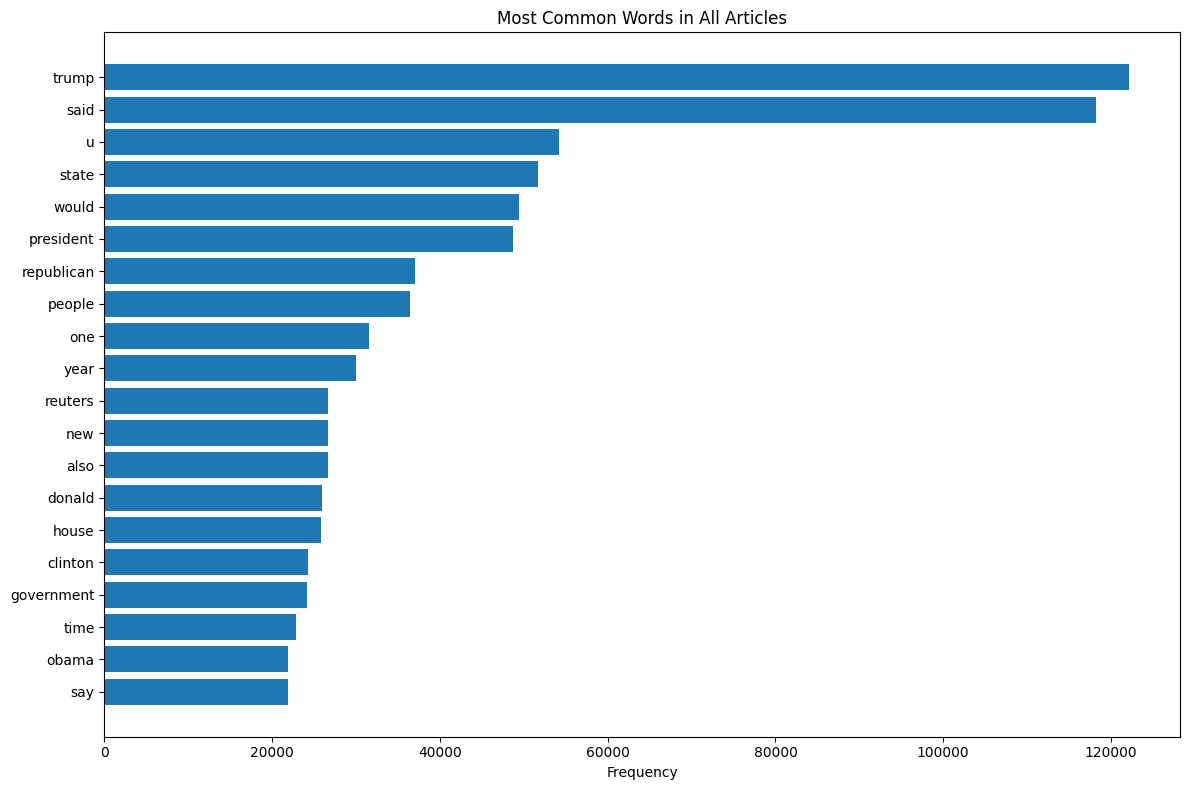

In [13]:
# Analyze most common words
print("=== WORD FREQUENCY ANALYSIS ===")

# Get all text
all_text = ' '.join(train_data['text'].astype(str))
all_text_clean = preprocess_text(all_text)

# Count word frequencies
words = all_text_clean.split()
word_freq = Counter(words)
most_common_words = word_freq.most_common(20)

print("Most common words in all articles:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Visualize most common words
words_list, counts_list = zip(*most_common_words)

plt.figure(figsize=(12, 8))
plt.barh(range(len(words_list)), counts_list)
plt.yticks(range(len(words_list)), words_list)
plt.xlabel('Frequency')
plt.title('Most Common Words in All Articles')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
# Compare word frequencies between fake and real news
print("=== WORD FREQUENCY COMPARISON ===")

# Get text for fake and real news separately
fake_text = ' '.join(fake_news['text'].astype(str))
real_text = ' '.join(real_news['text'].astype(str))

fake_text_clean = preprocess_text(fake_text)
real_text_clean = preprocess_text(real_text)

# Count frequencies
fake_words = fake_text_clean.split()
real_words = real_text_clean.split()

fake_freq = Counter(fake_words)
real_freq = Counter(real_words)

print("Most common words in FAKE news:")
for word, count in fake_freq.most_common(10):
    print(f"{word}: {count}")

print("\nMost common words in REAL news:")
for word, count in real_freq.most_common(10):
    print(f"{word}: {count}")

=== WORD FREQUENCY COMPARISON ===
Most common words in FAKE news:
trump: 68316
said: 25868
president: 22858
people: 22297
would: 19413
one: 19366
state: 17413
donald: 15737
like: 15146
republican: 15012

Most common words in REAL news:
said: 92386
trump: 53801
u: 39802
state: 34315
would: 30025
reuters: 26456
president: 25843
republican: 22072
year: 17926
government: 17909


## 6. Sample Articles Analysis

In [15]:
# Display sample articles
print("=== SAMPLE ARTICLES ===")

print("\n📰 SAMPLE FAKE NEWS ARTICLES:")
fake_samples = fake_news.head(3)
for idx, row in fake_samples.iterrows():
    print(f"\n--- Article {idx} ---")
    print(f"Title: {row['title']}")
    print(f"Subject: {row['subject']}")
    print(f"Date: {row['date']}")
    print(f"Text (first 200 chars): {row['text'][:200]}...")

print("\n📰 SAMPLE REAL NEWS ARTICLES:")
real_samples = real_news.head(3)
for idx, row in real_samples.iterrows():
    print(f"\n--- Article {idx} ---")
    print(f"Title: {row['title']}")
    print(f"Subject: {row['subject']}")
    print(f"Date: {row['date']}")
    print(f"Text (first 200 chars): {row['text'][:200]}...")

=== SAMPLE ARTICLES ===

📰 SAMPLE FAKE NEWS ARTICLES:

--- Article 19999 ---
Title:  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Subject: News
Date: December 31, 2017
Text (first 200 chars): Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former rea...

--- Article 20000 ---
Title:  Drunk Bragging Trump Staffer Started Russian Collusion Investigation
Subject: News
Date: December 31, 2017
Text (first 200 chars): House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investig...

--- Article 20001 ---
Title:  Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’
Subject: News
Date: December 30, 2017
Text (first 200 chars): On Friday, it was rev

## 7. Data Quality Assessment

In [16]:
# Assess data quality
print("=== DATA QUALITY ASSESSMENT ===")

# Check for duplicates
train_duplicates = train_data.duplicated().sum()
val_duplicates = validation_data.duplicated().sum()
print(f"Duplicate rows - Training: {train_duplicates}, Validation: {val_duplicates}")

# Check for empty text
train_empty_text = (train_data['text'].str.strip() == '').sum()
val_empty_text = (validation_data['text'].str.strip() == '').sum()
print(f"Empty text - Training: {train_empty_text}, Validation: {val_empty_text}")

# Check for very short text
train_short_text = (train_data['text'].str.len() < 50).sum()
val_short_text = (validation_data['text'].str.len() < 50).sum()
print(f"Very short text (<50 chars) - Training: {train_short_text}, Validation: {val_short_text}")

# Check for very long text
train_long_text = (train_data['text'].str.len() > 10000).sum()
val_long_text = (validation_data['text'].str.len() > 10000).sum()
print(f"Very long text (>10000 chars) - Training: {train_long_text}, Validation: {val_long_text}")

=== DATA QUALITY ASSESSMENT ===
Duplicate rows - Training: 201, Validation: 8
Empty text - Training: 610, Validation: 21
Very short text (<50 chars) - Training: 795, Validation: 41
Very long text (>10000 chars) - Training: 137, Validation: 215


## 8. Summary Statistics

In [17]:
# Summary statistics
print("=== SUMMARY STATISTICS ===")

print(f"\n📊 DATASET OVERVIEW:")
print(f"Training articles: {len(train_data):,}")
print(f"Validation articles: {len(validation_data):,}")
print(f"Total articles: {len(train_data) + len(validation_data):,}")

print(f"\n📈 LABEL DISTRIBUTION:")
print(f"Fake news: {(train_data['label'] == 0).sum():,} ({(train_data['label'] == 0).mean() * 100:.1f}%)")
print(f"Real news: {(train_data['label'] == 1).sum():,} ({(train_data['label'] == 1).mean() * 100:.1f}%)")

print(f"\n📝 TEXT STATISTICS:")
print(f"Average text length: {train_data['text_length'].mean():.0f} characters")
print(f"Average word count: {train_data['word_count'].mean():.0f} words")
print(f"Average title length: {train_data['title_length'].mean():.0f} characters")
print(f"Average title word count: {train_data['title_word_count'].mean():.0f} words")

print(f"\n📅 DATE RANGE:")
if 'date_parsed' in train_data.columns and train_data['date_parsed'].notna().any():
    valid_dates = train_data['date_parsed'].dropna()
    print(f"From: {valid_dates.min()}")
    print(f"To: {valid_dates.max()}")
    print(f"Span: {(valid_dates.max() - valid_dates.min()).days} days")
    print(f"Successfully parsed: {len(valid_dates):,} ({len(valid_dates)/len(train_data)*100:.1f}%)")
else:
    print("Date parsing not available")

print(f"\n🏷️ SUBJECTS:")
for subject, count in train_data['subject'].value_counts().items():
    print(f"{subject}: {count:,} articles")

=== SUMMARY STATISTICS ===

📊 DATASET OVERVIEW:
Training articles: 39,942
Validation articles: 4,956
Total articles: 44,898

📈 LABEL DISTRIBUTION:
Fake news: 19,943 (49.9%)
Real news: 19,999 (50.1%)

📝 TEXT STATISTICS:
Average text length: 2385 characters
Average word count: 392 words
Average title length: 80 characters
Average title word count: 12 words

📅 DATE RANGE:
From: 2015-03-31 00:00:00
To: 2018-02-19 00:00:00
Span: 1056 days
Successfully parsed: 39,934 (100.0%)

🏷️ SUBJECTS:
politicsNews: 11,272 articles
News: 9,050 articles
worldnews: 8,727 articles
politics: 6,841 articles
left-news: 2,482 articles
Government News: 1,570 articles


In [18]:
train_data.columns

Index(['label', 'title', 'text', 'subject', 'date', 'date_clean',
       'date_parsed', 'text_length', 'title_length', 'word_count',
       'title_word_count'],
      dtype='object')

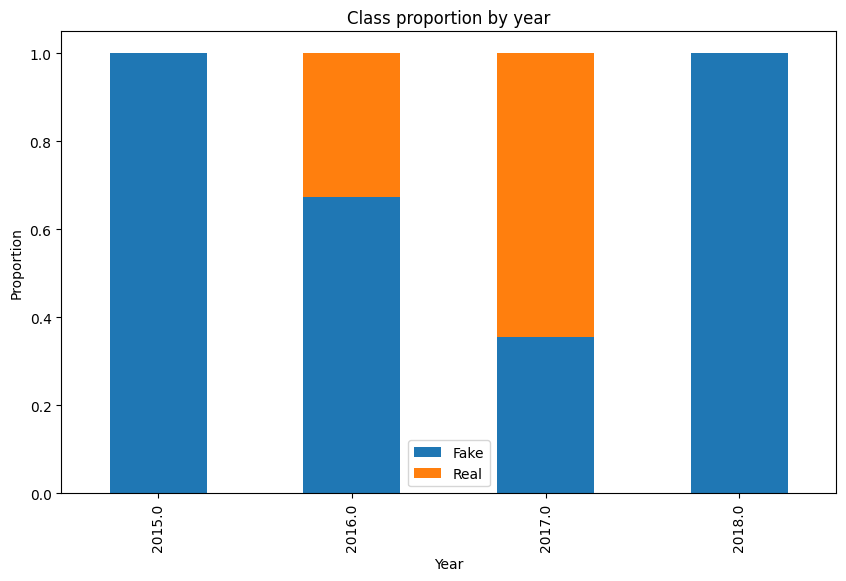

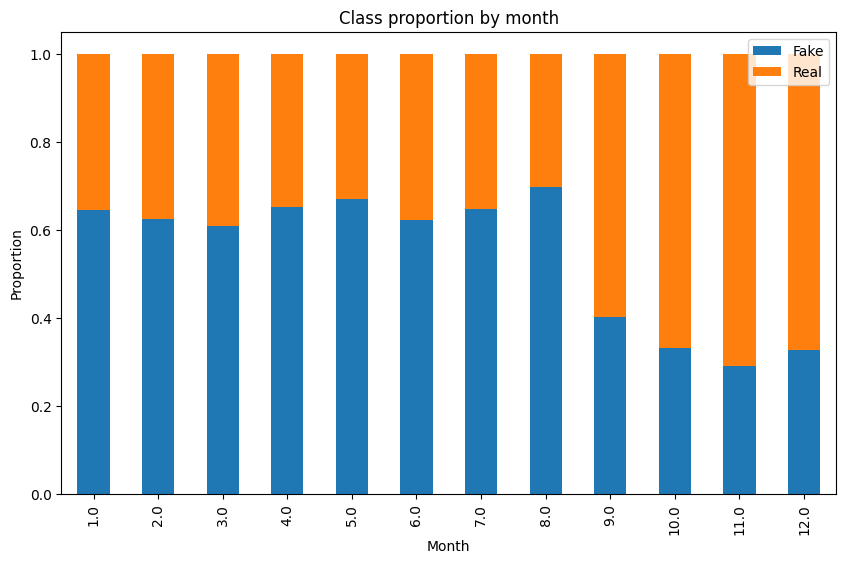

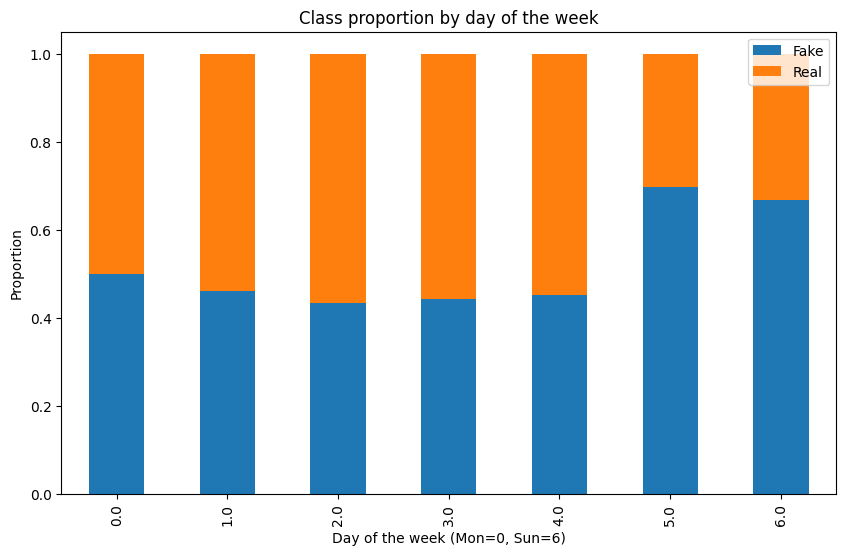

In [19]:
train_data['year'] = train_data['date_parsed'].dt.year
train_data['month'] = train_data['date_parsed'].dt.month
train_data['year_month'] = train_data['date_parsed'].dt.to_period('M')
train_data['day_of_week'] = train_data['date_parsed'].dt.dayofweek 

def plot_date_features(df, column_name, title, xlabel):
    df_plot = df.groupby(column_name)['label'].value_counts(normalize=True).unstack().fillna(0)
    
    if 0 not in df_plot.columns:
        df_plot[0] = 0
    if 1 not in df_plot.columns:
        df_plot[1] = 0
    
    df_plot.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Proportion')
    plt.legend(['Fake', 'Real'])
    plt.show()

plot_date_features(train_data, 'year', 'Class proportion by year', 'Year')
plot_date_features(train_data, 'month', 'Class proportion by month', 'Month')
plot_date_features(train_data, 'day_of_week', 'Class proportion by day of the week', 'Day of the week (Mon=0, Sun=6)')

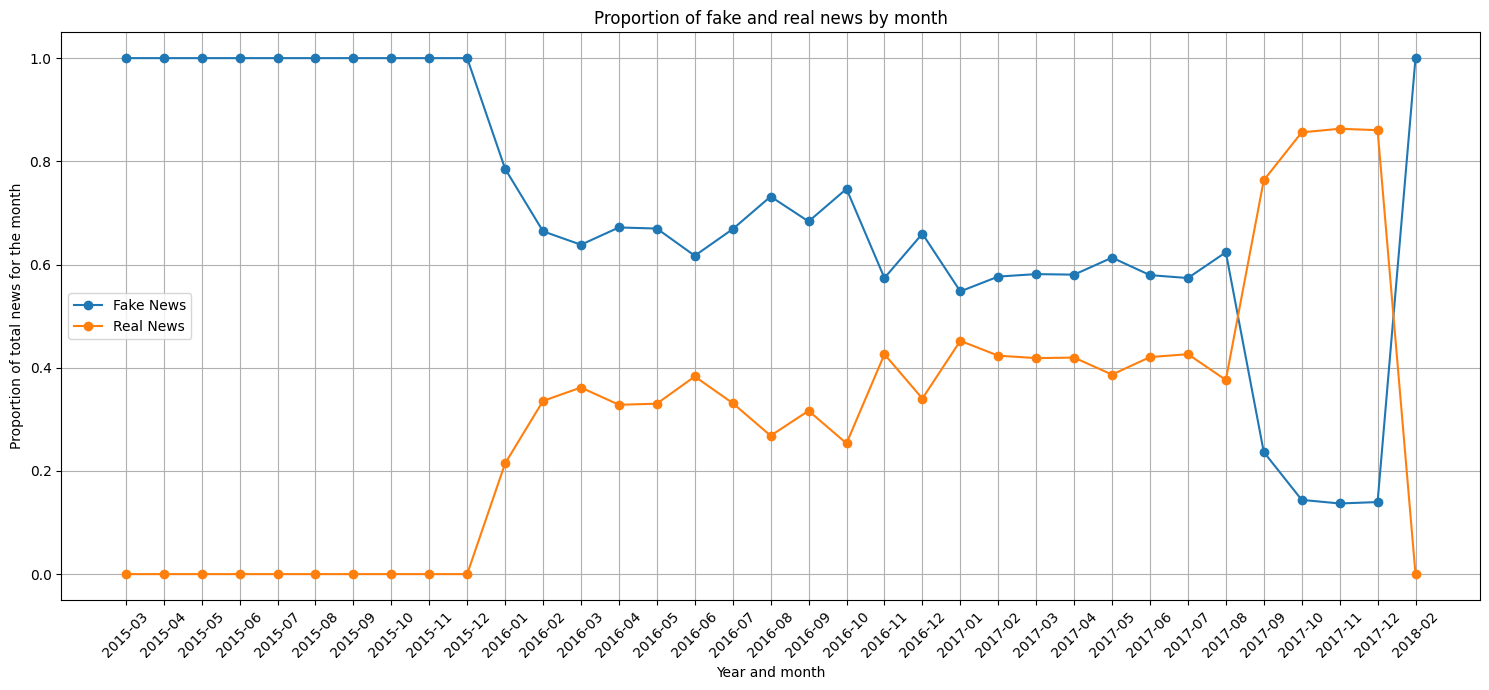

In [20]:
# Aggregate data by month and calculate normalized proportions
monthly_proportions = train_data.groupby('year_month')['label'].value_counts(normalize=True).unstack().fillna(0)

# Build a line chart
plt.figure(figsize=(15, 7))
plt.plot(monthly_proportions.index.astype(str), monthly_proportions[0], label='Fake News', marker='o')
plt.plot(monthly_proportions.index.astype(str), monthly_proportions[1], label='Real News', marker='o')

plt.title('Proportion of fake and real news by month')
plt.xlabel('Year and month')
plt.ylabel('Proportion of total news for the month')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

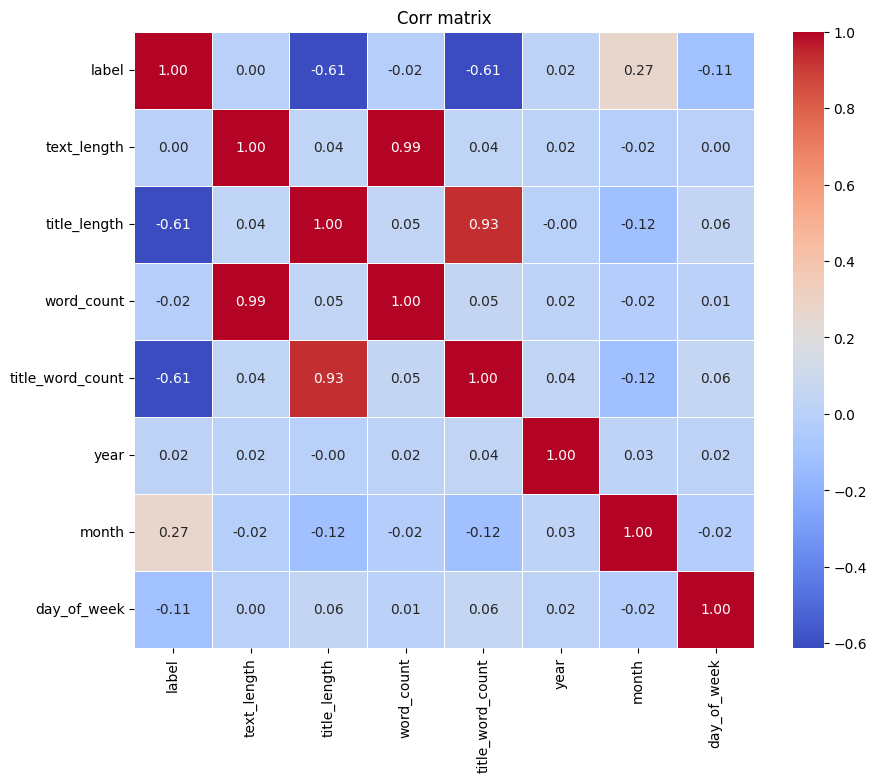

In [21]:
numerical_features = [
    'label', 'text_length', 'title_length', 'word_count', 
    'title_word_count', 'year', 'month', 'day_of_week'
]

corr_data = train_data[numerical_features].copy()


corr_data = corr_data.fillna(0)


correlation_matrix = corr_data.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Corr matrix')
plt.show()

## 9. Key Insights and Recommendations

In [22]:
# Key insights
print("=== KEY INSIGHTS ===")

print("\n🔍 DATA CHARACTERISTICS:")
print("• The dataset is well-balanced with roughly equal fake and real news")
print("• Text lengths vary significantly, indicating diverse article types")
print("• Multiple subjects are represented, providing good coverage")
print("• Date range spans multiple years, allowing temporal analysis")

print("\n📊 DISTRIBUTION PATTERNS:")
print("• Fake and real news have similar length distributions")
print("• Subject distribution shows some bias toward certain topics")
print("• Word frequency analysis reveals common terms in both categories")

print("\n⚠️ POTENTIAL CHALLENGES:")
print("• Some articles may have inconsistent formatting")
print("• Date parsing may require additional cleaning")
print("• Text preprocessing will be crucial for model performance")

print("\n💡 RECOMMENDATIONS:")
print("• Use text preprocessing to clean and normalize content")
print("• Consider feature engineering (length, word count, etc.)")
print("• Implement cross-validation for robust model evaluation")
print("• Use ensemble methods to improve classification accuracy")
print("• Consider temporal features if date parsing is successful")

=== KEY INSIGHTS ===

🔍 DATA CHARACTERISTICS:
• The dataset is well-balanced with roughly equal fake and real news
• Text lengths vary significantly, indicating diverse article types
• Multiple subjects are represented, providing good coverage
• Date range spans multiple years, allowing temporal analysis

📊 DISTRIBUTION PATTERNS:
• Fake and real news have similar length distributions
• Subject distribution shows some bias toward certain topics
• Word frequency analysis reveals common terms in both categories

⚠️ POTENTIAL CHALLENGES:
• Some articles may have inconsistent formatting
• Date parsing may require additional cleaning
• Text preprocessing will be crucial for model performance

💡 RECOMMENDATIONS:
• Use text preprocessing to clean and normalize content
• Consider feature engineering (length, word count, etc.)
• Implement cross-validation for robust model evaluation
• Use ensemble methods to improve classification accuracy
• Consider temporal features if date parsing is successf

In [23]:
train_data

,label,title,text,subject,date,date_clean,date_parsed,text_length,title_length,word_count,title_word_count,year,month,year_month,day_of_week
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017","December 31, 2017",2017-12-31,4659,64,749,10,2017.0,12.0,2017-12,6.0
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017","December 29, 2017",2017-12-29,4077,64,624,9,2017.0,12.0,2017-12,4.0
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017","December 31, 2017",2017-12-31,2789,60,457,10,2017.0,12.0,2017-12,6.0
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017","December 30, 2017",2017-12-30,2461,59,376,9,2017.0,12.0,2017-12,5.0
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017","December 29, 2017",2017-12-29,5204,69,852,11,2017.0,12.0,2017-12,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39937,0,THIS IS NOT A JOKE! Soros-Linked Group Has Pla...,"The Left has been organizing for decades, and ...",left-news,"Sep 22, 2016","Sep 22, 2016",2016-09-22,5026,124,841,20,2016.0,9.0,2016-09,3.0
39938,0,THE SMARTEST WOMAN In Politics: “How Trump Can...,Monica Crowley offers some of the most brillia...,left-news,"Sep 22, 2016","Sep 22, 2016",2016-09-22,4651,85,791,15,2016.0,9.0,2016-09,3.0
39939,0,BREAKING! SHOCKING VIDEO FROM CHARLOTTE RIOTS:...,Protest underway in Charlotte: Things got com...,left-news,"Sep 21, 2016","Sep 21, 2016",2016-09-21,189,81,26,12,2016.0,9.0,2016-09,2.0
39940,0,BREAKING! Charlotte News Station Reports Cops ...,"Local Charlotte, NC news station WSOCTV is rep...",left-news,"Sep 21, 2016","Sep 21, 2016",2016-09-21,2302,110,380,18,2016.0,9.0,2016-09,2.0
